# 1. Setup

1.1 Importing Libraries

In [1]:
import cv2
import os
import random
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt
import uuid

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

1.2 Limit GPU

In [2]:
# grabs all GPUs
gpus = tf.config.experimental.list_physical_devices("GPU")
# sets memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.3 Create Folder Structures

In [3]:
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [4]:
# make the directories
os.makedirs(os.path.join("data"))
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data'

# 2. Data Collection

2.1 Collect Positive and Anchor Images

In [ ]:
# import uuid (universally unique identifiers) library to generate unique image name 

In [5]:
cap = cv2.VideoCapture(0)
cap.set(3, 250)
cap.set(4, 250)

while True:
    ret, frame = cap.read() # reads each frame one by one
    
    # create positives
    if cv2.waitKey(1) & 0xFF == ord("p"):
        imname = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imname, frame)
    # create anchors
    if cv2.waitKey(1) & 0xFF == ord("a"):
        imname = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imname, frame)



    cv2.imshow("frame", frame) # shows image 
    if cv2.waitKey(20) & 0xFF == 27: # allows keyboard press to close window with the escape key
        break

# when finished, release the capture
cap.release() 
cv2.destroyAllWindows()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:967: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


2.2 Collect negative images

In [6]:
# http://vis-www.cs.umass.edu/lfw/
# download file from link

In [7]:
# uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
# move LFW Images to the following repository data/negative
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):
        CURRENT_PATH = os.path.join("lfw", directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(CURRENT_PATH, NEW_PATH)

# Data Processing

3.1 Get Image Directories

In [9]:
# count's how many files are in the folder
count = 0
for path in os.listdir(ANC_PATH):
    if os.path.isfile(os.path.join(ANC_PATH, path)):
        count += 1  
# takes the images into a tensorflow dataset
anchor = tf.data.Dataset.list_files(ANC_PATH+"/*.jpg").take(count)
positive = tf.data.Dataset.list_files(POS_PATH+"/*.jpg").take(count) 
negative = tf.data.Dataset.list_files(NEG_PATH+"/*.jpg").take(count)

3.2 Preprocess images

In [10]:
def preprocess(file_path):
    # reading img
    byte_img = tf.io.read_file(file_path)
    # using tf decode image to load it in
    img = tf.io.decode_jpeg(byte_img)
    # resizes img
    img = tf.image.resize(img, (100,100))
    # scales image to be between 0 and 1
    img = img / 255.0
    return img

In [11]:
# allows us to preprocess each image separately
def preprocess_seperate(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

3.3 Add them all into one dataset

In [12]:
# combines the anchor and positve/negative image. Adds 1.0/0.0 depending if same face
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

3.4 Splitting train and test data

In [13]:
#### Training ####
# takes 70% of images for training data
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(32)
# starts preprocessing the next set of images so that we don"t bottle neck our next set images
train_data = train_data.prefetch(2)

In [14]:
#### Testing ####
# skips first 70% of images
test_data = data.skip(round(len(data)*.8))
# then takes 30% of data left 
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(32)
test_data = test_data.prefetch(8)

# 4. Model Engineering

Credit:
https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
https://www.youtube.com/watch?v=LKispFFQ5GU&list=PLG_9Ujd97d8nAbnA3RIb1Gd6IWAHvB2ij&index=2&t=11281s

4.1 Build Embedding layer

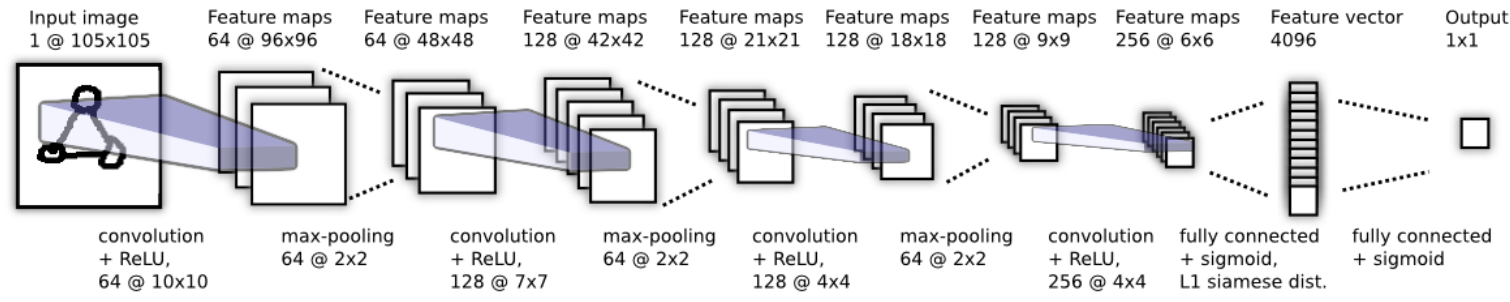

In [15]:
def make_embedding():
    inp = Input(shape=(100,100,3), name="input_image")

    #### First block ####
    # convolution takes in number of filters we want to pass through, and the filter shape e.g 10x10
    c1 = Conv2D(64, (10,10), activation="relu")(inp)
    # we again want 64, with the shape of 2x2, which condences down the amount of data. Padding=same replicates a similar output shape 
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)

    #### Second Block ####
    c2 = Conv2D(128, (7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

    #### Third Block ####
    c3 = Conv2D(128, (4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

    #### Final Embedding Block ####
    c4 = Conv2D(256, (4,4), activation="relu")(m3)
    # takes all the outputs of our convolution layer (which is 3d) and flattens it to 2d
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    # model class comes from the TensorFlow library, it will compile all our layers into a model
    # it will ensure it takes our input, then goes through all our layers, and give it the name of embedding
    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [16]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [17]:
class L1Dist(Layer):
    # **kwargs allows you to work with this specific layer as a part of the bigger model.
    def __init__(self, **kwargs):
        # performs inheritance on the function
        super().__init__()

    # our two inputs are now going to combine and be compared
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [18]:
def make_siamese_model():
    input_image = Input(name="input_img", shape=(100,100,3))
    validation_image = Input(name="validation_img", shape=(100,100,3))

    
    
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")

In [19]:
siamese_model = make_siamese_model()

# 5. Training

In [20]:
# the loss will be used later to be able to calculate our loss (1 or 0)
binary_loss = tf.losses.BinaryCrossentropy()
# improves speed and performance
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [21]:
#siamese_model.compile(optimizer="adam", loss=tf.losses.BinaryCrossentropy(), metrics=["recall"])

In [22]:
@tf.function # compiles our function into a callable TensorFlow graph
def train_step(batch):
    # allows us to capture our gradient from the model, records the operations for automatic differentiation
    with tf.GradientTape() as tape:
        x = batch[:2] # get anchor and positive/negative images
        y = batch[2] # takes the label

        # passes our data through the siamese model to make a prediction
        y_pred = siamese_model(x, training=True)
        # calculates the loss
        loss = binary_loss(y, y_pred)
    # calculates all of the gradients in respect to our loss for all of our trainable variables   
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss


In [23]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print(f"\n Epoch {epoch}/{EPOCHS}")
        progress_bar = tf.keras.utils.Progbar(len(data))

    for idx, batch in enumerate(data):
        train_step(batch)
        progress_bar.update(idx+1)

    if epoch % 10 == 0: 
        checkpoint.save(file_prefix=checkpoint_prefix)

In [24]:
train(train_data, 5)


 Epoch 1/5

 Epoch 2/5

 Epoch 3/5

 Epoch 4/5

 Epoch 5/5


ValueError: in user code:

    File "<ipython-input-22-bd9291f0e6ae>", line 9, in train_step  *
        y_pred = siamese_model(x, training=True)
    File "c:\Users\lukas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\lukas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "embedding" "                 f"(type Functional).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (32,)
    
    Call arguments received by layer "embedding" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(32,), dtype=float32)
      • training=True
      • mask=None
